In [128]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 9]
import rpy2.robjects as robjects

from rpy2.robjects.packages import importr
%load_ext rpy2.ipython



The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [202]:
#df = pd.read_pickle('data/prop_data_gap_12_2_1_05_ct_NEST.pkl').drop_duplicates()
df = pd.read_pickle('data/prop_data_2_ni_NEST.pkl').drop_duplicates()

In [219]:
# --------- FILTERING ------------
reps_discarded = [20,41]
exp = 'DIA'

time_win = 2 #h
max_gap = 10 #s

df_filt = df.loc[(df.time_win==3600 * time_win) & 
                 (df.max_gap==max_gap) & 
                (df.exp.isin([exp+'a',exp+'b'])) & 
                (~df.rep.isin(reps_discarded))]
df_filt.insert(4,'h', [int(str(a)[-8:-6]) for a in df_filt.start])
df_filt = df_filt.sort_values(['rep','h'])

rep_to_colony = {i: i for i in range(57)}
#df_filt.insert(5, 'colony', [rep_to_colony[j] for j in df_filt.rep])

# Export dataframe for stats
df_filt.to_csv('NTM_df_stats.csv')
df_filt


,rep,exp,start,time_win,h,max_gap,GC,ants,partition,MOD,...,wDEN,DIA,wDIA,RAD,wRAD,DEH,cDEH,wDEH,cwDEH,CLS
36,16,DIAa,2021-09-15 09:00:00,7200,9,10,153,177,6,0.214861,...,0.000307,4,3.10681,2,2.0,42.357772,35.325692,284.242736,256.774688,0.050386
42,16,DIAb,2021-09-13 09:00:00,7200,9,10,166,184,5,0.364671,...,0.000204,5,3.830818,3,2.0,34.246181,31.591997,202.51873,191.720902,0.037097
37,16,DIAa,2021-09-15 11:00:00,7200,11,10,153,177,5,0.26298,...,0.000256,4,2.783333,2,1.45,37.629546,31.71817,243.994036,222.951379,0.042247
43,16,DIAb,2021-09-13 11:00:00,7200,11,10,163,184,4,0.302904,...,0.000241,4,2.544007,3,1.333333,35.876855,31.732269,227.898058,209.777173,0.035202
38,16,DIAa,2021-09-15 13:00:00,7200,13,10,154,177,5,0.332536,...,0.000218,4,2.392857,2,1.25,33.740475,30.128333,221.761371,208.50569,0.0277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
477,53,DIAb,2021-12-17 15:00:00,7200,15,10,154,165,5,0.254038,...,0.000343,3,2.138889,2,1.083333,35.325447,29.531899,247.192345,230.098587,0.042197
472,53,DIAa,2021-12-19 17:00:00,7200,17,10,156,164,5,0.241689,...,0.000428,3,2.098824,2,1.058824,37.67567,32.939186,268.059513,248.919156,0.054734
478,53,DIAb,2021-12-17 17:00:00,7200,17,10,159,165,5,0.283346,...,0.000337,4,2.30395,2,1.2,34.209303,31.590448,211.80494,200.874044,0.034554
473,53,DIAa,2021-12-19 19:00:00,7200,19,10,159,164,5,0.246623,...,0.000459,3,2.1,2,1.0625,35.665032,32.048443,259.48315,245.048338,0.057359


In [220]:
%%R -i time_win -o prop_list -o pv_adj 

# -----------------------------
# Linear Mixed Effects Model (R)
# -----------------------------
rm(list=ls())
library(lme4)
library(car)

prop_list <- c('cMOD','wDIA','cwDEH','wDEN')
dat <- read.csv("NTM_df_stats.csv",header=T,stringsAsFactors = F)
  # list of properties for the LMER test
pv_list <- integer(0)

print(dat$head)
if (dat$time_win[1] == 12*3600){rf <- ' ~ exp +(1|rep)'}
    else{rf <- ' ~ exp +(1|rep)+(1|h)'}

for (prop in prop_list){
    model <- lmer(formula(paste(prop,rf)), data = dat)
    print(summary(model))
    pv_list <- c(pv_list, as.numeric(Anova(model)["exp","Pr(>Chisq)"]))
}

pv_adj <- p.adjust(pv_list, method="BH")
names(pv_adj) <- prop_list

print(pv_adj)

NULL
Linear mixed model fit by REML ['lmerMod']
Formula: cMOD ~ exp + (1 | rep) + (1 | h)
   Data: dat

REML criterion at convergence: -463.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.0139 -0.5956 -0.0629  0.5414  3.3471 

Random effects:
 Groups   Name        Variance  Std.Dev.
 rep      (Intercept) 8.283e-04 0.028781
 h        (Intercept) 5.578e-05 0.007469
 Residual             1.282e-03 0.035812
Number of obs: 132, groups:  rep, 11; h, 6

Fixed effects:
             Estimate Std. Error t value
(Intercept)  0.251543   0.010200  24.662
expDIAb     -0.017300   0.006234  -2.775

Correlation of Fixed Effects:
        (Intr)
expDIAb -0.306


R[write to console]: boundary (singular) fit: see ?isSingular



Linear mixed model fit by REML ['lmerMod']
Formula: wDIA ~ exp + (1 | rep) + (1 | h)
   Data: dat

REML criterion at convergence: 185.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.0679 -0.6681 -0.2756  0.2428  3.4235 

Random effects:
 Groups   Name        Variance Std.Dev.
 rep      (Intercept) 0.03284  0.1812  
 h        (Intercept) 0.00000  0.0000  
 Residual             0.21144  0.4598  
Number of obs: 132, groups:  rep, 11; h, 6

Fixed effects:
            Estimate Std. Error t value
(Intercept)  2.39372    0.07867  30.427
expDIAb      0.17240    0.08005   2.154

Correlation of Fixed Effects:
        (Intr)
expDIAb -0.509
optimizer (nloptwrap) convergence code: 0 (OK)
boundary (singular) fit: see ?isSingular

Linear mixed model fit by REML ['lmerMod']
Formula: cwDEH ~ exp + (1 | rep) + (1 | h)
   Data: dat

REML criterion at convergence: 1223.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.1261 -0.7012  0.0325  0.6558  2.5811 

Random effects:

In [221]:
pv_dict = {prop_list[i]: pv_adj[i] for i in range(len(pv_adj))}
pv_dict

{'cMOD': 0.02207278445935196,
 'wDIA': 0.0416829767733508,
 'cwDEH': 0.18425309296697812,
 'wDEN': 0.0416829767733508}

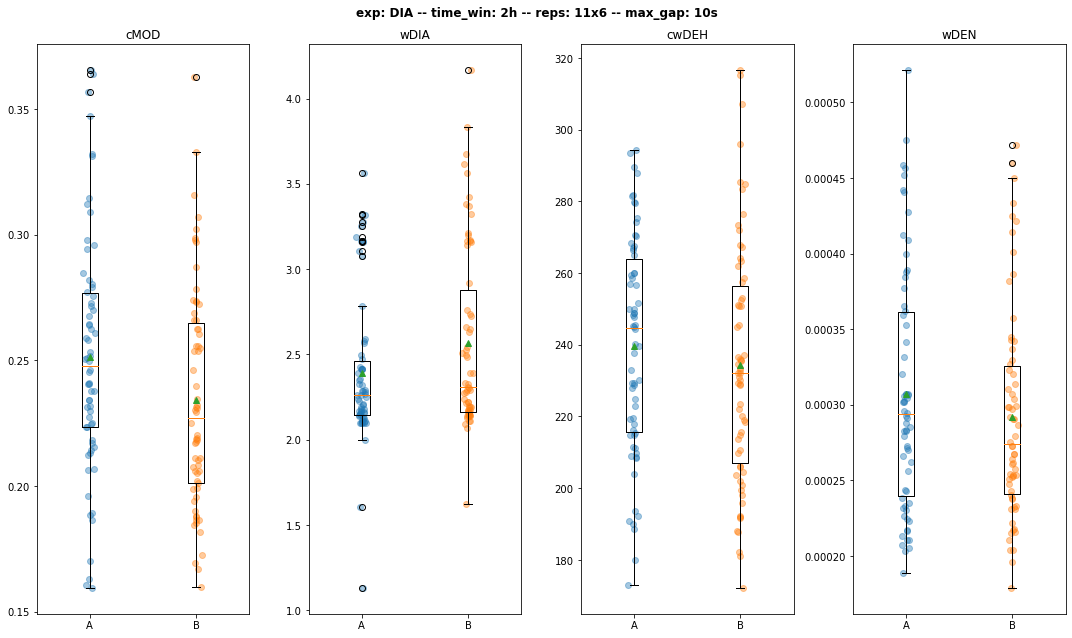

In [222]:
# Raw data specific property
fig, axs = plt.subplots(1, len(prop_list))

for idx_p, p in enumerate(prop_list):

    # dataframe for a-b comparison
    df_ab = pd.DataFrame()
    df_ab.insert(0, 'A', list(df_filt[p].iloc[::2]))
    df_ab.insert(1, 'B', list(df_filt[p].iloc[1::2]))
    df_ab


    # Plotting
    vals, names, xs = [],[],[]
    for i, col in enumerate(df_ab.columns):
        vals.append(df_ab[col].values)
        names.append(col)
        xs.append(np.random.normal(i + 1, 0.02, df_ab[col].values.shape[0]))  # adds jitter to the data points - can be adjusted


    box_plot = axs[idx_p].boxplot(vals, labels=names, showmeans=True)
    for x, val in zip(xs, vals):
        axs[idx_p].scatter(x, val, alpha=0.4)

    means = df_ab.mean()
    stds =  df_ab.std()
    
    axs[idx_p].set_title(p)
    
#     # statistical annotation
#     if pv_dict[p]<=0.05:
#         stat_sign = '*' + (pv_dict[p]<=0.01)*'*' + (pv_dict[p]<=0.001)*'*' + (pv_dict[p]<=0.0001)*'*'
#         x1, x2 = 1, 2   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
#         mm =np.max(df_ab.max())
#         y, h, col = 1.05*mm, 0.01*mm, 'k'
#         axs[idx_p].plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
#         axs[idx_p].text((x1+x2)*.5, y+h, stat_sign, ha='center', va='bottom', color=col, fontsize=20)

title = 'exp: ' + exp + ' -- time_win: ' + str(time_win) + 'h' + ' -- reps: ' + str(int(len(df_ab)*time_win/12)) + 'x' + str(int(12/time_win)) +  ' -- max_gap: ' + str(max_gap) + 's'
fig = plt.suptitle(title, fontweight="bold")
plt.tight_layout()
plt.savefig('plots/' + title + '_num_int.png')
plt.show()

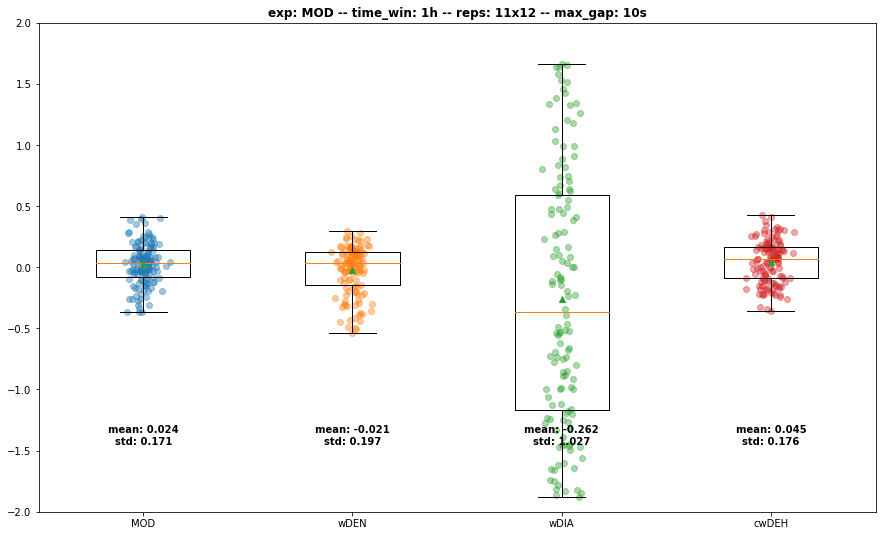

In [119]:
#===== RELATIVE DIFFERENCE =====


# ---- dataframe of relative difference---- 
p = ['MOD', 'wDEN', 'wDIA', 'cwDEH']
df_rd = (df_filt[p].diff()/df_filt[p].rolling(2).mean()).iloc[1::2]
df_rd.insert(0,'rep', df_filt.rep.iloc[1::2])
df_rd.insert(1,'exp', [a[0:3] for a in df_filt.exp.iloc[1::2]])
df_rd.insert(3,'start-b', list(df_filt.start.iloc[1::2]))

vals, names, xs = [],[],[]
for i, col in enumerate(df_rd[p].columns):
    vals.append(df_rd[col].values)
    names.append(col)
    xs.append(np.random.normal(i + 1, 0.04, df_rd[col].values.shape[0]))  # adds jitter to the data points - can be adjusted

plt.figure()
box_plot = plt.boxplot(vals, labels=names, showmeans=True)
for x, val in zip(xs, vals):
    plt.scatter(x, val, alpha=0.4)

means = df_rd[p].mean()
stds =  df_rd[p].std()

for xtick in range(len(p)):
    plt.text(xtick+1,-1.35, 'mean: {:.3f}'.format(means[xtick]), 
              horizontalalignment='center',size='medium',color='k',weight='semibold')
    plt.text(xtick+1,-1.45, 'std: {:.3f}'.format(stds[xtick]), 
                  horizontalalignment='center',size='medium',color='k',weight='semibold')

plt.ylim([-2,2])
fig = plt.title('exp: ' + exp + 
                ' -- time_win: ' + str(time_win) + 'h'
                ' -- reps: ' + str(int(len(df_rd)*time_win/12)) + 'x' + str(int(12/time_win)) + 
                ' -- max_gap: ' + str(max_gap) + 's',
               fontweight="bold")